# GraphML Session 03


## OSM Analysis

Here we'll add weights to our graph based on nearby amenities as described in Open Street Maps.

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.0 MB/s eta 0:00:00


In [2]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

We start by gettin a location:

In [41]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
from shapely import affinity
import numpy as np

class RotatedGridGenerator:
    def __init__(self, place_name, grid_size=113, rotation_angle=-45):
        """
        place_name: str - the name of the location (e.g. "Poblenou, Barcelona, Spain")
        grid_size: int - the grid cell size in meters (width = height)
        rotation_angle: float - clockwise rotation in degrees (e.g., -45)
        """
        self.place_name = place_name
        self.grid_size = grid_size
        self.rotation_angle = rotation_angle
        self.city_boundary = self._get_boundary()
        self.crs = self.city_boundary.crs
        self.grid = self._generate_rotated_grid()

    def _get_boundary(self):
        """Download and return the city or neighborhood boundary"""
        return ox.geocode_to_gdf(self.place_name).to_crs(epsg=3857)

    def _generate_rotated_grid(self):
        """Create a rotated square grid clipped to the city boundary"""
        minx, miny, maxx, maxy = self.city_boundary.total_bounds
        cells = []
        for x in np.arange(minx, maxx, self.grid_size):
            for y in np.arange(miny, maxy, self.grid_size):
                cell = box(x, y, x + self.grid_size, y + self.grid_size)
                cells.append(cell)

        # Rotate grid around city center
        cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, self.rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=self.crs)
        grid = gpd.overlay(grid, self.city_boundary, how="intersection")
        grid["cell_id"] = range(len(grid))
        return grid

    def get_grid(self):
        """Return the rotated clipped grid as a GeoDataFrame"""
        return self.grid

    def plot(self, ax=None, **kwargs):
        """Quick visualization of the grid"""
        if ax is None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10, 10))
        self.city_boundary.boundary.plot(ax=ax, edgecolor="blue")
        self.grid.plot(ax=ax, edgecolor="red", facecolor="none", **kwargs)
        ax.set_title(f"Rotated Grid on {self.place_name} (size={self.grid_size}m, angle={self.rotation_angle}°)")
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax

<Axes: title={'center': 'Rotated Grid on Poblenou, Barcelona, Spain (size=226m, angle=-45°)'}>

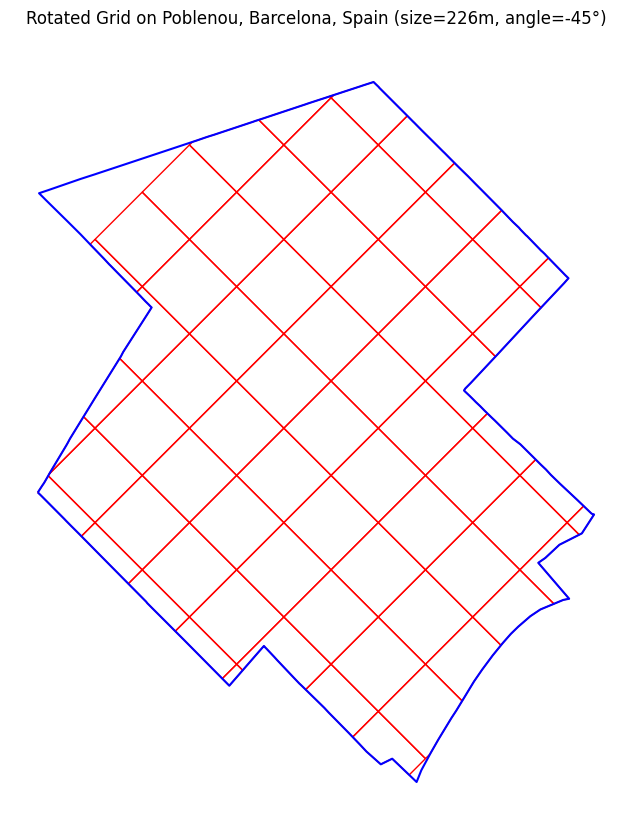

In [42]:
# Create a grid over Poblenou, with 2x2 blocks per cell (~226m), rotated 45°
gridgen = RotatedGridGenerator("Poblenou, Barcelona, Spain", grid_size=226, rotation_angle=-45)

# Get the grid as GeoDataFrame
grid = gridgen.get_grid()

# Plot it
gridgen.plot()

In [52]:
place_name = "Poblenou, Barcelona, Spain"
G = ox.graph_from_place(place_name, network_type="drive")

Next, we define what kind of "amenities" do we want to extract from OSM.

Key values to look for refer to https://wiki.openstreetmap.org/wiki/Map_Features


In [67]:
# set value to True for all values pairable to the key
# key = "amenity"
value_nomnom = {"amenity":["bar","restaurant","pub","cafe","fast_food"]}
value_couchcounty = {"amenity":["apartments", "bungalow", "detached", "annex", "dormitory", "house", "residential", "semidetached_house", "stilt_house"]}
value_HustleHub = {"amenity":["commercial", "khiosk", "office", "retail", "supermarket"]}
# value_smokestackland = {"amenity":["industrial", "warehouse"]}

# Download the Points of interest
# tags = {key: value}
tags_couch = value_couchcounty
tags_nomnom = value_nomnom
tags_HustleHub = value_HustleHub
# tags_smokestackland = value_smokestackland

#the list of spaces
couch_list = ox.features.features_from_place(place_name, tags=tags_couch)
nomnom_list = ox.features.features_from_place(place_name, tags=tags_nomnom)
HustleHub_list = ox.features.features_from_place(place_name, tags=tags_HustleHub)
# smoke_list = ox.features.features_from_place(place_name, tags=tags_smokestackland)
print(couch_list)
print(nomnom_list)
print(HustleHub_list)
# smokestackland_list

                                    geometry addr:housenumber addr:postcode  \
element id                                                                    
node    6064566288  POINT (2.20559 41.40011)               15         08005   

                            addr:street    amenity entrance               name  
element id                                                                      
node    6064566288  Carrer de l'Amistat  dormitory      yes  Associació In Via  
                                                             geometry  \
element id                                                              
node    660100527                            POINT (2.19677 41.40469)   
        660100529                            POINT (2.19419 41.40486)   
        660771772                             POINT (2.19776 41.4035)   
        660778771                             POINT (2.19865 41.4029)   
        660784487                             POINT (2.1989 41.40273)   
...     

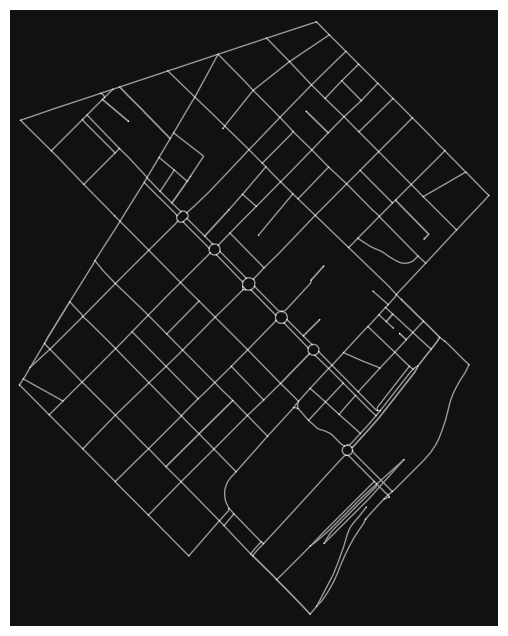

(237, 76)
(1, 7)
(1, 3)


In [69]:
ox.plot_graph(G, node_size=1)
print(nomnom_list.shape)
print(couch_list.shape)
print(HustleHub_list.shape)

In [6]:
# Filter out non-points geometry
gdf_pts = gdf.loc[gdf.geometry.geometry.type=='Point']
gdf_pts.shape
gdf_pts

geometry     amenity           cuisine  \
element id                                                                    
node    364731424    POINT (2.16218 41.38952)  restaurant          japanese   
        570117144    POINT (2.16234 41.40217)  restaurant          regional   
        587998431    POINT (2.16217 41.40204)  restaurant           catalan   
        588002549    POINT (2.16194 41.40189)         bar               NaN   
        588003295    POINT (2.16205 41.40193)  restaurant           mexican   
...                                       ...         ...               ...   
        12806048901  POINT (2.16976 41.40121)  restaurant     mediterranean   
        12851679701  POINT (2.16593 41.38907)  restaurant  regional;spanish   
        12851695101  POINT (2.16593 41.38907)  restaurant  regional;spanish   
        12883049781  POINT (2.16282 41.39176)  restaurant               NaN   
        12911087701  POINT (2.15182 41.39398)  restaurant          georgian   

                                  name  \
element id                               
node    364731424            Hanibishi   
        570117144            Cal Boter   
        587998431           Fonda Pepa   
        588002549            La Cigale   
        588003295       Sabes una Cosa   
...                                ...   
        12806048901         CASA CHELI   
        12851679701          La Lolita   
        12851695101          La Lolita   
        12883049781   Tapería Catalana   
        12911087701  Restaurante Kinza   

                                                     opening_hours  \
element id                                                           
node    364731424                 PH,Mo-Su 13:00-16:30,19:00-23:30   
        570117144                                              NaN   
        587998431                                              NaN   
        588002549                                              NaN   
        588003295    Mo-Fr 20:00-23:30; Sa 13:30-15:30,20:00-23:30   
...                                                            ...   
        12806048901                                            NaN   
        12851679701                                            NaN   
        12851695101                              Mo-Su 08:00-00:00   
        12883049781                                            NaN   
        12911087701                              Mo-Su 13:00-00:00   

                    addr:housenumber              addr:street  check_date  \
element id                                                                  
node    364731424                NaN                      NaN         NaN   
        570117144                 62        Carrer de Tordera  2024-10-25   
        587998431                 58        Carrer de Tordera  2024-10-25   
        588002549                NaN                      NaN  2024-07-03   
        588003295                 54        Carrer de Tordera  2024-08-08   
...                              ...                      ...         ...   
        12806048901              226  Carrer de Roger de Flor         NaN   
        12851679701               27      Rambla de Catalunya         NaN   
        12851695101               27      Rambla de Catalunya         NaN   
        12883049781              NaN                      NaN         NaN   
        12911087701              179          Carrer d'Aribau         NaN   

                        name:ca             phone  ... mobile  \
element id                                         ...          
node    364731424           NaN               NaN  ...    NaN   
        570117144     Cal Boter               NaN  ...    NaN   
        587998431    Fonda Pepa  +34 93 207 22 53  ...    NaN   
        588002549           NaN               NaN  ...    NaN   
        588003295           NaN  +34 672 53 42 59  ...    NaN   
...                         ...               ...  ...    ...   
        12806048901         N

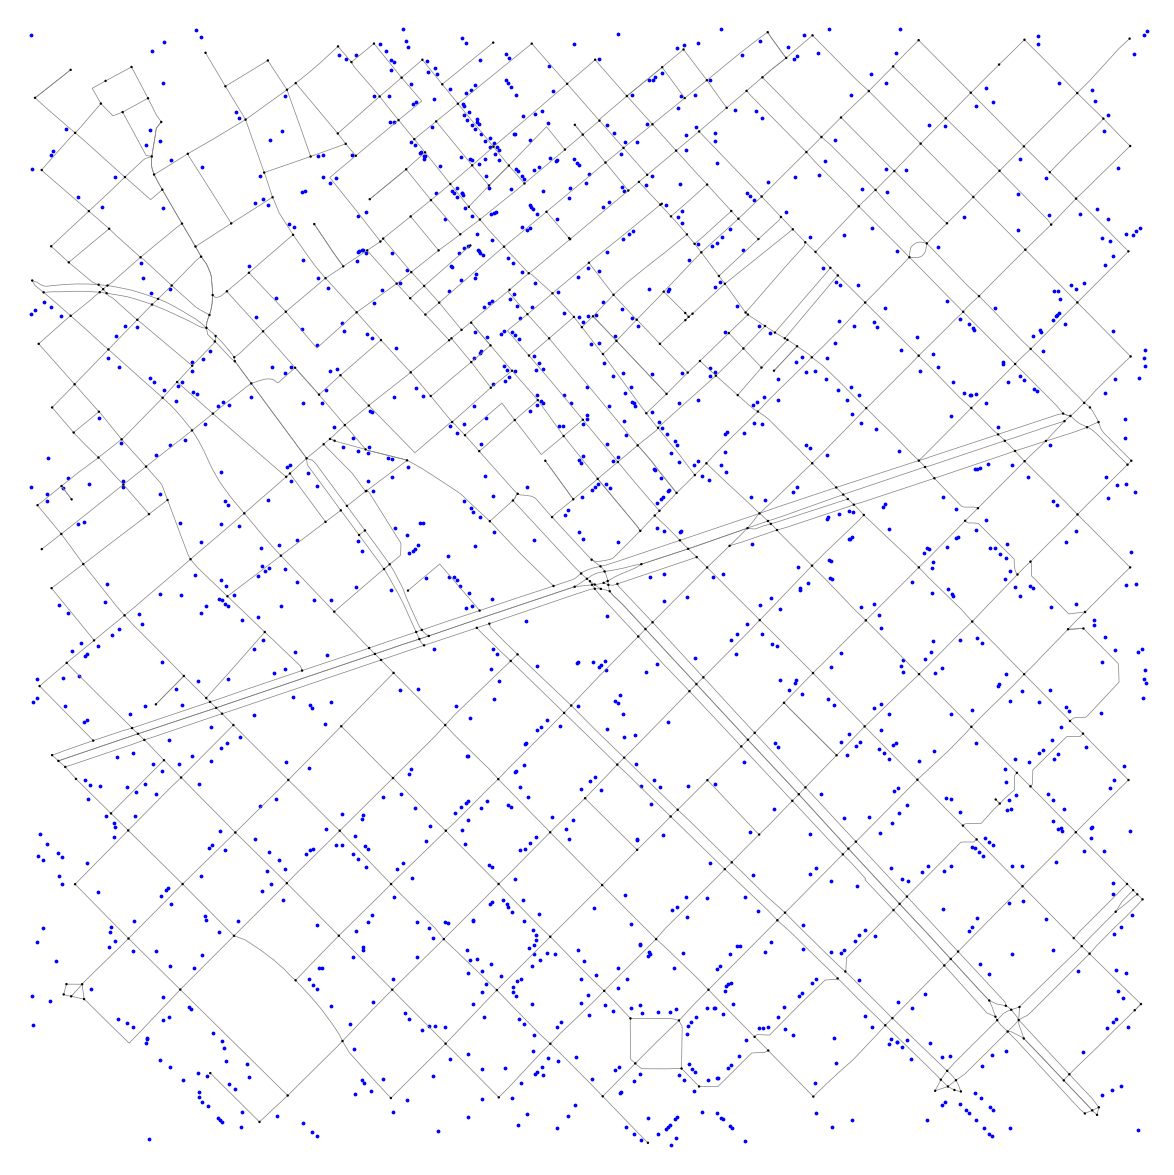

In [7]:
# Start plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot GeoDataFrame
gdf_pts.plot(ax=ax, color='blue', markersize=3)

# Draw the graph
ox.plot_graph(G, ax=ax, node_size=3, node_color= "black", edge_linewidth=0.5, edge_color='gray')

plt.show()

In [8]:
# Reproject to a projected crs (meters)
crs = 3857 #mercator

G_proj = ox.projection.project_graph(G, to_crs=crs)
gdf_pts_proj = ox.projection.project_gdf(gdf_pts, to_crs=crs)

In [9]:
display(pd.DataFrame(gdf_pts_proj['geometry']))
display(pd.DataFrame(gdf_pts_proj['geometry'].x))
pd.DataFrame(gdf_pts_proj['geometry'].y)

geometry
element id                                         
node    364731424    POINT (240692.432 5069966.425)
        570117144     POINT (240710.71 5071843.304)
        587998431    POINT (240691.641 5071825.154)
        588002549    POINT (240666.271 5071802.715)
        588003295     POINT (240678.75 5071808.651)
...                                             ...
        12806048901  POINT (241536.812 5071700.803)
        12851679701    POINT (241109.69 5069899.61)
        12851695101    POINT (241109.69 5069899.61)
        12883049781  POINT (240764.344 5070299.411)
        12911087701   POINT (239539.05 5070628.772)

[1459 rows x 1 columns]

0
element id                        
node    364731424    240692.431513
        570117144    240710.710173
        587998431    240691.641145
        588002549    240666.271433
        588003295    240678.750348
...                            ...
        12806048901  241536.812115
        12851679701  241109.690360
        12851695101  241109.690360
        12883049781  240764.343904
        12911087701  239539.050269

[1459 rows x 1 columns]

0
element id                       
node    364731424    5.069966e+06
        570117144    5.071843e+06
        587998431    5.071825e+06
        588002549    5.071803e+06
        588003295    5.071809e+06
...                           ...
        12806048901  5.071701e+06
        12851679701  5.069900e+06
        12851695101  5.069900e+06
        12883049781  5.070299e+06
        12911087701  5.070629e+06

[1459 rows x 1 columns]

In [10]:
# Get the nearest edge per point
G_dist = ox.distance.nearest_edges(G_proj, X=gdf_pts_proj['geometry'].x, Y=gdf_pts_proj['geometry'].y)

In [11]:
G_dist

array([(30247434, 3314294600, 0), (30554511, 30554509, 0),
       (30554511, 30554509, 0), ..., (301573106, 301573130, 0),
       (301572279, 301572306, 0), (30237615, 30237635, 0)], dtype=object)

In [12]:
# Decompose the graph
G_nodes, G_edges = ox.graph_to_gdfs(G_proj)

In [13]:
# Count occurences in distance df
occurences = Counter(G_dist)

In [14]:
occurences

Counter({(30247434, 3314294600, 0): 6,
         (30554511, 30554509, 0): 4,
         (415935008, 30553978, 0): 1,
         (30558446, 6238824734, 0): 2,
         (30237643, 30237642, 0): 6,
         (1400448338, 1400448339, 0): 3,
         (11466476299, 11466476297, 0): 12,
         (442540236, 442540237, 0): 2,
         (269369082, 442540235, 0): 3,
         (11053280241, 442540253, 0): 6,
         (301572132, 301572243, 0): 2,
         (301573106, 301573130, 0): 7,
         (301572963, 3207831035, 0): 1,
         (30554971, 30554851, 0): 9,
         (30554850, 567448762, 0): 3,
         (30237641, 30237699, 0): 3,
         (30237641, 30237640, 0): 7,
         (30237640, 30237639, 0): 4,
         (30237698, 30237699, 0): 6,
         (30237640, 30237698, 0): 2,
         (30247089, 30238023, 0): 8,
         (559787231, 559787232, 0): 3,
         (30243263, 33098963, 0): 5,
         (30556631, 30254381, 0): 1,
         (30243202, 30243203, 0): 5,
         (30333330, 30556748, 0): 7,
    

In [15]:
type(occurences)

collections.Counter

In [16]:
occurences_df = pd.DataFrame(list(occurences.items()), columns=['name', 'count'])
occurences_df

,name,count
0,"(30247434, 3314294600, 0)",6
1,"(30554511, 30554509, 0)",4
2,"(415935008, 30553978, 0)",1
3,"(30558446, 6238824734, 0)",2
4,"(30237643, 30237642, 0)",6
...,...,...
497,"(30248594, 30248595, 0)",1
498,"(60969509, 60969502, 0)",1
499,"(30553975, 30554977, 0)",1
500,"(30243206, 442540293, 0)",1


In [17]:
for item, count in occurences.most_common(10):
    print(item, count)

(7580972991, 7198688932, 0) 16
(11061736176, 10181609591, 0) 13
(11466476299, 11466476297, 0) 12
(30554852, 30554851, 0) 12
(30237700, 30237642, 0) 11
(10893712430, 11012442316, 0) 11
(30243366, 30237641, 0) 11
(3314294600, 3207831035, 0) 11
(11053219723, 30237643, 0) 11
(301572460, 344992889, 0) 10


In [18]:
for i in G_edges.index:
    print(i)
    # print(G_edges.loc[i])
    # print(G_edges['name'])
    # print(G_edges.loc[i].name)

(26057312, 269369082, 0)
(26057312, 3229689808, 0)
(269369082, 442540235, 0)
(269369082, 1311770050, 0)
(3229689808, 30254225, 0)
(30237612, 30237613, 0)
(30237612, 30247089, 0)
(30237613, 30237633, 0)
(30237613, 30237614, 0)
(30247089, 1589583464, 0)
(30247089, 30238023, 0)
(30237633, 1311773901, 0)
(30237633, 30237632, 0)
(30237614, 30237615, 0)
(30237614, 30237696, 0)
(30237615, 30237635, 0)
(30237615, 30237616, 0)
(30237696, 30237772, 0)
(30237696, 30237697, 0)
(30237635, 30237634, 0)
(30237635, 30237637, 0)
(30237616, 30247166, 0)
(30237616, 30237617, 0)
(30247166, 30237638, 0)
(30247166, 30247167, 0)
(30237617, 30247432, 0)
(30247432, 30247166, 0)
(30247432, 30247433, 0)
(30237632, 30237612, 0)
(1311773901, 30237770, 0)
(30237634, 30237614, 0)
(30237634, 30237633, 0)
(30237637, 30247431, 0)
(30237637, 1362899971, 0)
(30247431, 1311619368, 0)
(30247431, 30237617, 0)
(1362899971, 1311619488, 0)
(1362899971, 1311619340, 0)
(1362899971, 359104407, 0)
(30237638, 30237615, 0)
(30237638

In [19]:
# Initialize empty list for values
cost = [] # number of occurences

# Map occurences to G_edge df
for i in G_edges.index:
    # print(i)
    # print(G_edges.loc[i])
    # print(G_edges.loc[i].name)
    # the referance goes to dictionary
    occurence = occurences[G_edges.loc[i].name]
    # print(occurence)
    cost.append(occurence)

# Double check that remapping worked
print( 'remapped pts:',sum(cost),'/', len(G_dist))

# Harmonize weights?
# cost = [item / max(cost) for item in cost]

# Update the graph
G_edges['repulsive'] = cost # this is inverse of attractive, here we take the shortest path by using the minimum amenities number out of collected numbers
G_edges['attractive'] = [((max(cost))-item) for item in cost] # this is inverse of repulsive, here we take the shortest path, that is the smallest weight of max-number

G_cost = ox.graph_from_gdfs(G_nodes,G_edges)

remapped pts: 1459 / 1459


In [20]:
ex_repulsive = [5, 12, 3, 7, 2, 8, 5, 12, 3, 2, 8, 5]
ex_attractive = [max(ex_repulsive) - el for el in ex_repulsive]
# the negative inverse is not possible, as shortest_path should work with positive numbers
print(f'REPULSIVE: the initial list of weights: {ex_repulsive}, the shortest_path will pick the street with a smallest number')
print(f'ATTRACTIVE: the (max-initial), INVERSED list of weights: {ex_attractive}, the shortest path will pick the smallest item from list, that will represent the most crowded street')

REPULSIVE: the initial list of weights: [5, 12, 3, 7, 2, 8, 5, 12, 3, 2, 8, 5], the shortest_path will pick the street with a smallest number
ATTRACTIVE: the (max-initial), INVERSED list of weights: [7, 0, 9, 5, 10, 4, 7, 0, 9, 10, 4, 7], the shortest path will pick the smallest item from list, that will represent the most crowded street


In [21]:
G_edges

osmid        highway  \
u           v           key                                                     
26057312    269369082   0                            304693491       tertiary   
            3229689808  0                            545718428        primary   
269369082   442540235   0                            116343002  living_street   
            1311770050  0                            116343003       tertiary   
3229689808  30254225    0    [1392183136, 18522669, 545718430]        primary   
...                                                        ...            ...   
11282472015 11276298354 0                           1217655908      secondary   
11289475293 126797988   0                            876196208       tertiary   
11466476297 559765964   0                              8380873    residential   
12884439772 11282472012 0                           1391901670    residential   
            11282472015 0                           1391901668       tertiary   

                            lanes maxspeed                               name  \
u           v           key                                                     
26057312    269369082   0       4       50                  Passeig de Gràcia   
            3229689808  0       2       50    Gran Via de les Corts Catalanes   
269369082   442540235   0       1       10  Passeig de Gràcia (lateral Besòs)   
            1311770050  0       4       50                  Passeig de Gràcia   
3229689808  30254225    0       5       50    Gran Via de les Corts Catalanes   
...                           ...      ...                                ...   
11282472015 11276298354 0       4       30              Plaça del Cinc d'Oros   
11289475293 126797988   0     NaN       30   Plaça de Mossèn Jacint Verdaguer   
11466476297 559765964   0       1       30                Rambla de Catalunya   
12884439772 11282472012 0       1       10              Plaça del Cinc d'Oros   
            11282472015 0       2      NaN                  Passeig de Gràcia   

                             oneway width reversed      length  \
u           v           key                                      
26057312    269369082   0      True     8    False   12.050670   
            3229689808  0      True    14    False   15.586845   
269369082   442540235   0      True   NaN    False  130.309460   
            1311770050  0      True   NaN    False   31.357246   
3229689808  30254225    0      True    14    False  155.871229   
...                             ...   ...      ...         ...   
11282472015 11276298354 0      True   NaN    False   16.128628   
11289475293 126797988   0      True    15    False   13.298126   
11466476297 559765964   0      True   NaN    False   22.098478   
12884439772 11282472012 0      True   NaN    False    7.424986   
            11282472015 0      True   NaN    False   10.500394   

                                                                      geometry  \
u           v           key                                                      
26057312    269369082   0    LINESTRING (241381.844 5069977.495, 241371.736...   
            3229689808  0    LINESTRING (241381.844 5069977.495, 241397.173...   
269369082   442540235   0    LINESTRING (241368.953 5069986.902, 241366.95 ...   
            1311770050  0    LINESTRING (241368.953 5069986.902, 241346.088...   
3229689808  30254225    0    LINESTRING (241401.592 5069984.023, 241407.314...   
...                                                                        ...   
11282472015 11276298354 0    LINESTRING (240386.704 5070993.508, 240397.546...   
11289475293 126797988   0    LINESTRING (241569.919 5071416.668, 241562.772...   
11466476297 559765964   0    LINESTRING (241261.564 5069782.184, 241254.729...   
12884439772 11282472012 0    LINESTRING (240375.149 5071001.432, 240379.98 ...   
            11282472015 0    LINESTRING (240375.149 5071001.432, 240380.815...   

                       

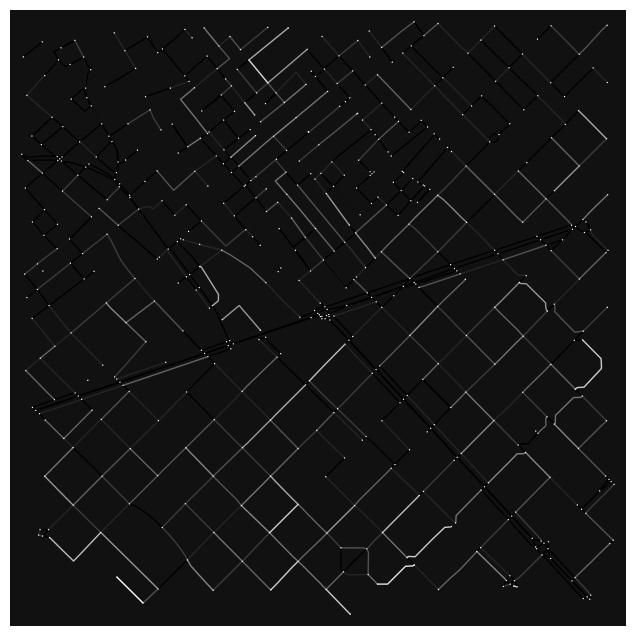

In [22]:
# Plot graph with custom weights
ec = ox.plot.get_edge_colors_by_attr(G_cost, attr="repulsive",  cmap="Greys_r")

fig, ax = ox.plot_graph(G_cost, node_size=1, edge_color=ec, edge_linewidth=1)

In [23]:
# Calculate Shortest path with custom weight
orig = list(G_cost)[1]
dest = list(G_cost)[300]

route_cost = ox.shortest_path(G_cost, orig, dest, weight="repulsive")
route_cost_neg = ox.shortest_path(G_cost, orig, dest, weight="attractive")

In [24]:
# get source node(s)
source_node = [orig]
# iterate through the nodes and apply parameters
node_color = ['red' if node in source_node else 'white' for node in G.nodes()]
node_size = [100 if node in source_node else 5 for node in G.nodes()]

In [25]:
route_cost

[269369082,
 1311770050,
 30243053,
 30242864,
 33098957,
 1311770048,
 30243371,
 1311770053,
 1311770051,
 8043162354,
 11282472027,
 1311619517,
 1311619514,
 1311619365,
 3141525071,
 9782230123,
 9782230121,
 442540256,
 1126848499,
 1311619424,
 1124790711,
 30243245,
 30243205,
 126803357,
 126797987,
 30243116,
 30243115,
 30243114,
 30555002,
 1487126966,
 30555001,
 126803336,
 30243203,
 415935111,
 415935210,
 126699974,
 1445340186,
 30554542,
 1445340182,
 30333335]

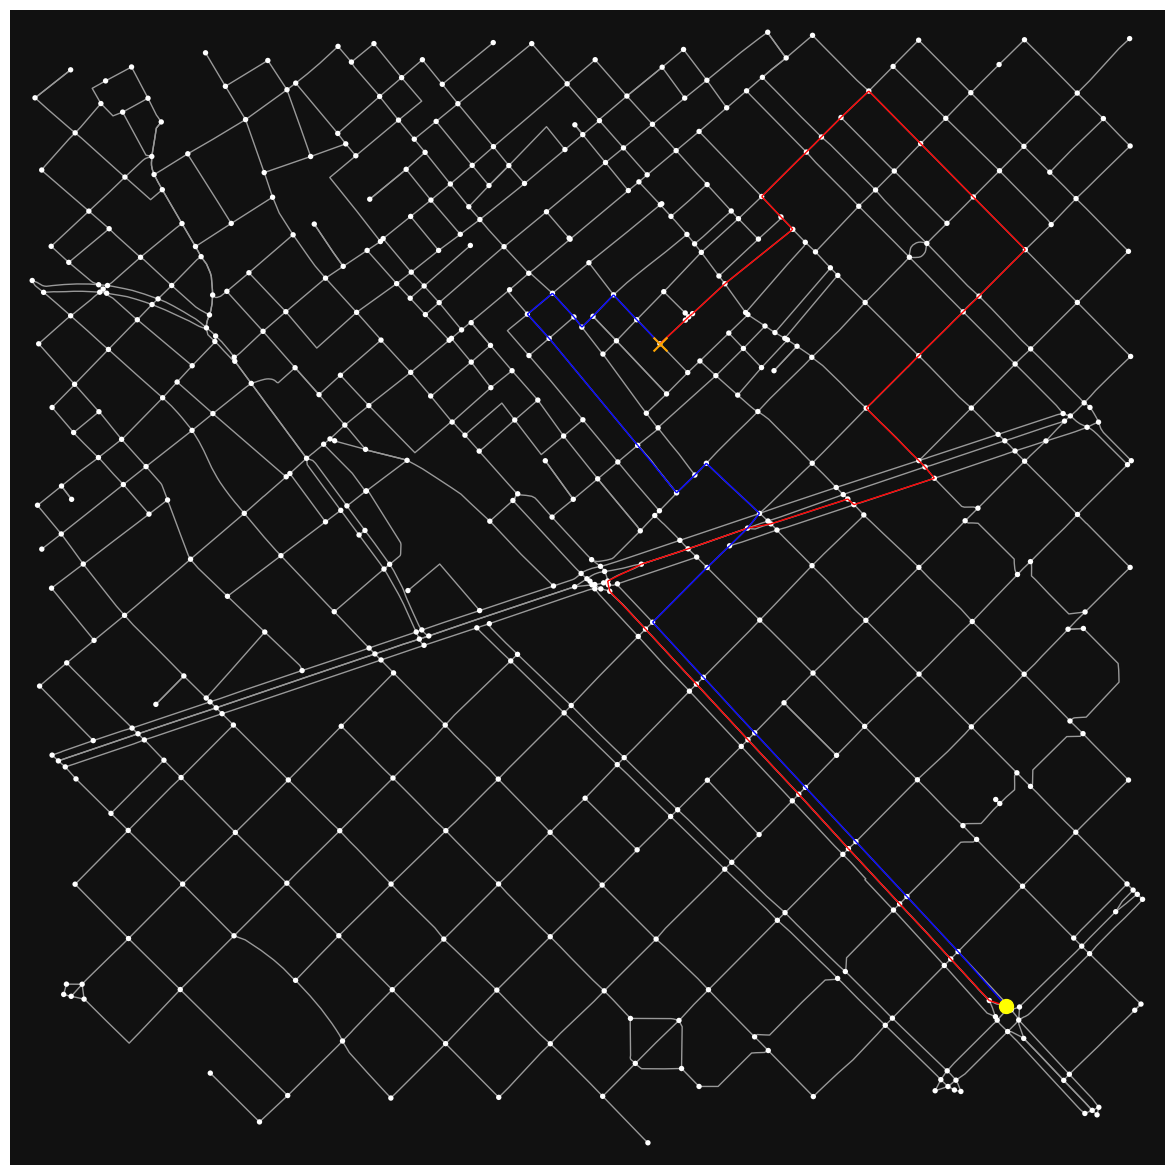

In [26]:
# Plot the graph
fig, ax = ox.plot_graph(G,  figsize=(15, 15), show=False, close=False)

# Get node positions, stored in node attribute 'pos'
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Highlight route_cost in red
path_edges_A = list(zip(route_cost[:-1], route_cost[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges_A, edge_color='red', width=1, ax=ax, arrows=False)

# Highlight route_cost_neg in blue
path_edges_B = list(zip(route_cost_neg[:-1], route_cost_neg[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges_B, edge_color='blue', width=1, ax=ax, arrows=False)

# Highlight the source nodes for both paths
source_nodes = {route_cost[0], route_cost_neg[0]}
nx.draw_networkx_nodes(G, pos, nodelist=list(source_nodes), node_color='yellow', node_size=100, ax=ax)

# Highlight the target nodes for both paths with 'X' marker
target_nodes = {route_cost[-1], route_cost_neg[-1]}
nx.draw_networkx_nodes(G, pos, nodelist=list(target_nodes), node_color='orange', node_size=100, node_shape='x', ax=ax)


# Show the plot
plt.show()